<ipython-input-1-e915db662661>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Selected Lag Order:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        39.22       39.26   1.074e+17       39.23
1        38.99      39.11*   8.549e+16      39.04*
2       38.97*       39.18  8.370e+16*       39.05
3        38.97       39.27   8.438e+16       39.09
4        39.01       39.40   8.789e+16       39.17
5        38.98       39.44   8.464e+16       39.17
6        39.00       39.55   8.699e+16       39.23
7        39.04       39.68   9.059e+16       39.30
8        39.08       39.80   9.416e+16       39.37
9        39.14       39.94   9.950e+16       39.46
10       39.15       40.04   1.011e+17       39.51
11       39.13       40.11   9.935e+16       39.53
12       39.09       40.15   9.508e+16       39.52
13       39.13       40.27   9.952e+16       39.59
14       39.12       40.35   9.931e+16       39.62
15       39.16       40.47   1.027e+17       39.69
----------

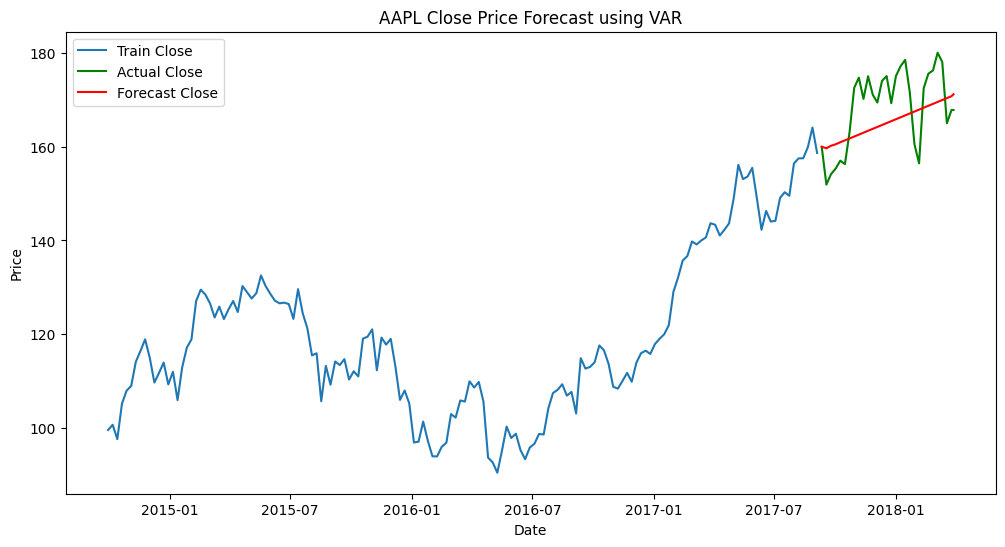

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, meanabs

# 1. Load dataset
data = pd.read_csv('/content/AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 2. Select relevant features (multivariate)
df = data[['Close', 'Volume']].copy()

# 3. Handle missing values
df = df.fillna(method='ffill')

# 4. Split into train and test
n_obs = 30  # number of observations for testing
train, test = df[:-n_obs], df[-n_obs:]

# 5. Check for stationarity - Difference the series
train_diff = train.diff().dropna()

# 6. Fit VAR model
model = VAR(train_diff)
lag_order = model.select_order(maxlags=15)
print("Selected Lag Order:\n", lag_order.summary())

selected_lag = lag_order.aic  # choose based on AIC
var_model = model.fit(selected_lag)

# 7. Forecast
forecast_input = train_diff.values[-selected_lag:]
forecast = var_model.forecast(y=forecast_input, steps=n_obs)

# 8. Convert forecast to DataFrame and reverse differencing
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Close', 'Volume'])
forecast_cumsum = forecast_df.cumsum()
last_known = train.iloc[-1]
forecast_values = forecast_cumsum + last_known

# 9. Evaluation
print("\n Evaluation Metrics (Close Price):")
print("MAE:", meanabs(test['Close'], forecast_values['Close']))
print("RMSE:", rmse(test['Close'], forecast_values['Close']))

# 10. Plotting
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Train Close')
plt.plot(test['Close'], label='Actual Close', color='green')
plt.plot(forecast_values['Close'], label='Forecast Close', color='red')
plt.title('AAPL Close Price Forecast using VAR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
